# 사용 패키지

In [54]:
# 기본 툴
import pandas as pd
import numpy as np

# 시각화 툴
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# 전처리 툴
from sklearn.preprocessing import Imputer

# 클러스터링 툴
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift,estimate_bandwidth

# 예측 전처리 툴
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 예측모델링 툴
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, plot_importance

# 군집,예측결과 평가 툴
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score

# 편의 툴
import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [5]:
train = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/기술통계19.xlsx',index_col='global_id')
service = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/실태조사_서비스업19.xlsx',index_col='global_id')
product = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/실태조사_제조업19.xlsx',index_col='global_id')

# 전처리 for cluster

In [44]:
warnings.filterwarnings(action='ignore')
# 기술통계 -실태조사 중복자료 추출
companys = [service, product]
for i in range(len(companys)):
    line = []
    for index in train.index:
        if index in companys[i].index:
            line.append(index)
        else:
            line.append(0)
    if i == 0:
        service_train =train[train.index == line]
        service_train['bt'] = 0
        print('중복되는 서비스업종 데이터개수: {}'.format(len(service_train)))
    else:
        product_train =train[train.index == line]
        product_train['bt'] = 2
        print('중복되는 제조업종 데이터개수: {}'.format(len(product_train)))
train = pd.concat([service_train, product_train])
index_list = ['A1S1', 'A1N1', 'C2S2', 'H1_1', 'H4_1', 'I4Q1', 'I4Q2',  'I4Q3', 'I4Q4', 'I4Q5', 'I4Q6', 'I4Q7']
my_train = train.loc[:, index_list]
print('')
# 결측치처리
for index in index_list:
    freq = my_train[index].value_counts(dropna=True).idxmax()
    my_train[index].fillna(freq, inplace = True)
    
# 응답 범주 축소화
warnings.filterwarnings(action='ignore')
my_train['A1S1']=my_train['A1S1'].replace({1:1,2:1,3:2,4:3,5:3,
                                        6:1,7:4})
my_train['A1N1']=my_train['A1N1'].replace({1:1,2:1,3:4,4:3,5:3,
                                        6:3,7:4,8:3,9:3,10:2,11:2,12:3,13:5,14:5,15:5})
my_train['C2S2']=my_train['C2S2'].replace({1:1,2:2,3:3,4:2})
my_train['H1_1']=my_train['H1_1'].replace({1:3,2:1,3:1,4:2,5:2,6:2,7:2,8:4,9:4})
my_train['H4_1']=my_train['H4_1'].replace({1:1,2:4,3:1,4:2,5:3,6:3,7:5,8:6,9:5,10:6})
my_train['I4Q1']=my_train['I4Q1'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q2']=my_train['I4Q2'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q3']=my_train['I4Q3'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q4']=my_train['I4Q4'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q5']=my_train['I4Q5'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q6']=my_train['I4Q6'].replace({1:3,2:2,3:1,4:1,5:1})
my_train['I4Q7']=my_train['I4Q7'].replace({1:3,2:2,3:1,4:1,5:1})

# 전처리된 원본 저장해두기
my_train_original = my_train[:]

# Dummy변수 생성
my_train_dummy = my_train[:]
for index in index_list:
    my_train_dummy[index] = my_train_dummy[index].astype(str)
    my_train_dummy = pd.get_dummies(my_train_dummy, columns=[index])
print('범주형 자료를 처리하기 위해 더미 변수를 생성')
print('')
# PCA5 데이터
my_train_pca = my_train[:]
pca = PCA(n_components = 10)
pca.fit(my_train_pca)
percentile = []
for i in pca.explained_variance_ratio_:
    if len(percentile) ==0:
        percentile.append(i)
    else:
        percentile.append(percentile[-1]+i)
print('PCA의 데이터반영 누적비율')
print(percentile[:5])
my_train_pca = my_train_original[:]
pca = PCA(n_components=5).fit(my_train_pca)
my_train_pca = pca.transform(my_train_pca)
print('데이터 약 80%보존 위해 5차원 선택')
print(' ')

#Dummy + PCA9
my_train_dummy_pca = my_train_dummy[:]

pca = PCA(n_components = 10)
pca.fit(my_train_dummy_pca)
percentile = []
for i in pca.explained_variance_ratio_:
    if len(percentile) ==0:
        percentile.append(i)
    else:
        percentile.append(percentile[-1]+i)
print('PCA의 데이터반영 누적 비율')
print(percentile[:9])

my_train_dummy_pca = my_train_dummy[:]
pca = PCA(n_components=9).fit(my_train_dummy_pca)
my_train_dummy_pca = pca.transform(my_train_dummy_pca)
print('데이터 70% 이상의 보존위해 9차원 선택!')

중복되는 서비스업종 데이터개수: 195
중복되는 제조업종 데이터개수: 834

범주형 자료를 처리하기 위해 더미 변수를 생성

PCA의 데이터반영 누적비율
[0.35325210435208265, 0.503054986879599, 0.6259350761808382, 0.7226038694708989, 0.7905081628716684]
데이터 약 80%보존 위해 5차원 선택
 
PCA의 데이터반영 누적 비율
[0.22929053470015992, 0.3427129100817887, 0.42022613950240456, 0.4852876516793557, 0.542998484366944, 0.598609255072028, 0.6463204392047819, 0.682626519749056, 0.7183204318359595]
데이터 70% 이상의 보존위해 9차원 선택!


# Clustering

In [45]:
#########Spectral
# 일반
spectral = SpectralClustering(n_clusters=3, n_init=10)
spectral_predict = spectral.fit_predict(my_train)
my_train_original['Spectral'] = spectral_predict
# Dummy
spectral_dummy_predict = spectral.fit_predict(my_train_dummy)
my_train_original['Spectral_dummy'] = spectral_dummy_predict
# PCA
spectral_pca_predict = spectral.fit_predict(my_train_pca)
my_train_original['Spectral_pca'] = spectral_pca_predict
# Dummy+PCA
spectral_dummy_pca_predict = spectral.fit_predict(my_train_dummy_pca)
my_train_original['Spectral_dummy_pca'] = spectral_dummy_pca_predict

##############DBSCAN
model = DBSCAN(eps=2.4,min_samples=150)

# 일반
dbscan = model.fit(my_train)
dbscan_predict=dbscan.fit_predict(my_train)
my_train_original['dbscan'] = dbscan_predict
# PCA
dbscan_pca = model.fit(my_train_pca)
dbscan_pca_predict=dbscan_pca.fit_predict(my_train_pca)
my_train_original['dbscan_pca'] = dbscan_pca_predict
# dummy
dbscan_dummy = model.fit(my_train_dummy)
dbscan_dummy_predict=dbscan_dummy.fit_predict(my_train_dummy)
my_train_original['dbscan_dummy'] = dbscan_dummy_predict
# dummy_pca
dbscan_dummy_pca = model.fit(my_train_dummy_pca)
dbscan_dummy_pca_predict=dbscan_dummy_pca.fit_predict(my_train_dummy_pca)
my_train_original['dbscan_dummy_pca'] = dbscan_dummy_pca_predict

##################AGG
# 일반
agg = AgglomerativeClustering(n_clusters=3).fit(my_train)
agg_predict=agg.fit_predict(my_train)
my_train_original['agg'] = agg_predict
# PCA
agg_pca = AgglomerativeClustering(n_clusters=3).fit(my_train_pca)
agg_pca_predict=agg_pca.fit_predict(my_train_pca)
my_train_original['agg_pca'] = agg_pca_predict
# dummy
agg_dummy = AgglomerativeClustering(n_clusters=3).fit(my_train_dummy)
agg_dummy_predict=agg_dummy.fit_predict(my_train_dummy)
my_train_original['agg_dummy'] = agg_dummy_predict
# dummy_pca
agg_dummy_pca = AgglomerativeClustering(n_clusters=3).fit(my_train_dummy_pca)
agg_dummy_pca_predict=agg_dummy_pca.fit_predict(my_train_dummy_pca)
my_train_original['agg_dummy_pca'] = agg_dummy_pca_predict

# 실루엣 스코어
print('Spectral  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, spectral_predict)))
print('Spectral_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, spectral_dummy_predict)))
print('Spectral_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, spectral_pca_predict)))
print('Spectral_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, spectral_dummy_pca_predict)))
print('----------------------')
print('AGG  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, agg_predict)))
print('AGG_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, agg_dummy_predict)))
print('AGG_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, agg_pca_predict)))
print('AGG_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, agg_dummy_pca_predict)))
print('----------------------')
print('DBscan  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, dbscan_predict)))
# print('DBscan_dummy  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, dbscan_pca)))
# print('DBscan_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, dbscan_pca_predict)))
# print('DBscan_dummy_pca  - silhouette score: {:.3f}'.format(silhouette_score(my_train_original, dbscan_dummy_pca_predict)))
print('----------------------')

# 결과저장
cluster_result = my_train_original['Spectral_pca']
cluster_result.to_csv('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/0514/cluster_result.csv', index=True)

Spectral  - silhouette score: 0.266
Spectral_dummy  - silhouette score: 0.259
Spectral_pca  - silhouette score: 0.188
Spectral_dummy_pca  - silhouette score: 0.237
----------------------
AGG  - silhouette score: 0.201
AGG_dummy  - silhouette score: 0.167
AGG_pca  - silhouette score: 0.227
AGG_dummy_pca  - silhouette score: 0.142
----------------------
DBscan  - silhouette score: 0.150
----------------------


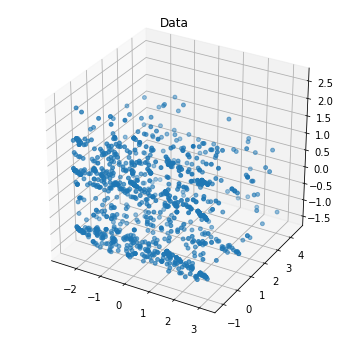

In [46]:
my_train_show = my_train[:]
pca = PCA(n_components=3).fit(my_train_show)
pca_train = pca.transform(my_train_show)
plt.rcParams["figure.figsize"] = (6,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_train[:, 0], pca_train[:, 1], pca_train[:,2], marker='o', s=15)
ax.set_title('Data')
plt.show()

Text(0.5, 0.92, 'Spectral_data')

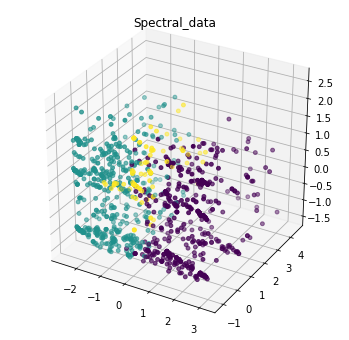

In [47]:
plt.rcParams["figure.figsize"] = (6,6)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_train[:, 0], pca_train[:, 1], pca_train[:,2], c=spectral_dummy_predict, marker='o', s=15)
ax.set_title('Spectral_data')

# 전처리 for prediction

In [48]:
train_ = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/기술통계19.xlsx',index_col='global_id')
service_ = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/실태조사_서비스업19.xlsx',index_col='global_id')
normal_ = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/실태조사_일반항목19.xlsx',index_col='global_id')
product_ = pd.read_excel('C:/Users/user/Desktop/Statistical_Data_Idea_Contest/DATA/데이터/실태조사_제조업19.xlsx',index_col='global_id')

In [49]:
train = train_[:]
service = service_[:]
normal = normal_[:]
product = product_[:]

In [51]:
# 서비스업 전처리
cols = [c for c in service.columns if c[:4] == 'INC_']
service=service[cols]
for i in cols:
    service[i] = service[i].replace(' - ',np.nan)
    service[i] = service[i].replace(',','')    
for i in cols:
    service = service.astype({i: float})
    
cols2 = ['INC_A_01','INC_A_02','INC_A_03','INC_A_04','INC_A_05','INC_A_06','INC_A_07','INC_A_08','INC_A_09','INC_A_10','INC_A_11','INC_A_12','INC_A_13','INC_A_14','INC_A_15','INC_A_16','INC_A_17','INC_A_18','INC_A_19','INC_A_20','INC_A_22','INC_A_23','INC_A_24','INC_A_25','INC_A_26','INC_A_27','INC_A_28','INC_A_29','INC_A_30','INC_A_31','INC_A_32','INC_A_33','INC_A_34']
service.drop(service[cols2],axis='columns',inplace=True)

service.INC_A_21 = service.INC_A_21.fillna(service.INC_A_21.mean())
service['y']=(service['INC_A_21']-service['INC_A_61'])/service['INC_A_61']
cols3= ['INC_A_41','INC_A_42','INC_A_45','INC_A_46','INC_A_47','INC_A_48','INC_A_49','INC_A_50','INC_A_51','INC_A_52','INC_A_53','INC_A_54','INC_A_55','INC_A_56','INC_A_57','INC_A_58','INC_A_59','INC_A_60','INC_A_61','INC_A_63','INC_A_64','INC_A_65','INC_A_67','INC_A_68','INC_A_69','INC_A_71','INC_A_73','y']
service = service[cols3]
service.isnull().sum()
delete_na = ['INC_A_53','INC_A_54', 'INC_A_58', 'INC_A_59', 'INC_A_64', 'INC_A_68', 'INC_A_73']
service.drop(service[delete_na],axis='columns',inplace=True)
for i in service.columns:
    service[i] = service[i].fillna(service[i].mean())
service['y3']=service['y'] >= 0
service['y3']=service['y3'].astype(float)
service['y3']=service['y3'].astype(str)

# 제조업 전처리
cols = [c for c in product.columns if c[:4] == 'INC_']
product=product[cols]
for i in cols:
    product[i] = product[i].replace(' - ',np.nan)
    product[i] = product[i].replace(',','')    
for i in cols:
    product = product.astype({i: float})
    
cols2 = ['INC_A_01','INC_A_02','INC_A_03','INC_A_04','INC_A_05','INC_A_06','INC_A_07','INC_A_08','INC_A_09','INC_A_10','INC_A_11','INC_A_12','INC_A_13','INC_A_14','INC_A_15','INC_A_16','INC_A_17','INC_A_18','INC_A_19','INC_A_20','INC_A_22','INC_A_23','INC_A_24','INC_A_25','INC_A_26','INC_A_27','INC_A_28','INC_A_29','INC_A_30','INC_A_31','INC_A_32','INC_A_33','INC_A_34']
product.drop(product[cols2],axis='columns',inplace=True)

product.INC_A_21 = product.INC_A_21.fillna(product.INC_A_21.mean())
product['y']=(product['INC_A_21']-product['INC_A_61'])/product['INC_A_61']
cols3= ['INC_A_41','INC_A_42','INC_A_45','INC_A_46','INC_A_47','INC_A_48','INC_A_49','INC_A_50','INC_A_51','INC_A_52','INC_A_53','INC_A_54','INC_A_55','INC_A_56','INC_A_57','INC_A_58','INC_A_59','INC_A_60','INC_A_61','INC_A_63','INC_A_64','INC_A_65','INC_A_67','INC_A_68','INC_A_69','INC_A_71','INC_A_73','y']
product = product[cols3]
product.isnull().sum()
delete_na = ['INC_A_53','INC_A_54', 'INC_A_58', 'INC_A_59', 'INC_A_64', 'INC_A_68', 'INC_A_73']
product.drop(product[delete_na],axis='columns',inplace=True)
for i in product.columns:
    product[i] = product[i].fillna(product[i].mean())
product['y3']=product['y'] >= 0
product['y3']=product['y3'].astype(float)
product['y3']=product['y3'].astype(str)

## Y3 변수 : 기업의 성장여부 (1 or 0)

# 서비스 데이터

In [68]:
### 기술통계에 잇는것과 없는것으로 train(겹치지않는것) test (겹치는것) 나누기
line3=[]
for i in service.index:
    if i in train.index:
        line3.append(i)
    else:
        line3.append(0)
service_test=service[service.index == line3]
service_test['test'] = 1
line4=[]
for i in service.index:
    if not i in train.index:
        line4.append(i)
    else:
        line4.append(0)
service_train=service[service.index == line4]
service_train['test'] = 0
col_list = ['INC_A_41', 'INC_A_42', 'INC_A_45', 'INC_A_46', 'INC_A_47', 'INC_A_48',
       'INC_A_49', 'INC_A_50', 'INC_A_51', 'INC_A_52', 'INC_A_55', 'INC_A_56',
       'INC_A_57', 'INC_A_60', 'INC_A_61', 'INC_A_63', 'INC_A_65', 'INC_A_67',
       'INC_A_69', 'INC_A_71']
train_X = service_train[col_list]
train_Y = service_train['y3']
test_X = service_test[col_list]
test_Y = service_test['y3']

# 로지스팃을 위한 정규화
scaler = StandardScaler()
#fit_transform 은 fit과 transform을 합친 건데, fit은 일단 각 속성(feature)마다 컬럼을 만드는 작업이라고 생각하면 된다. 이후 transform을 통해 데이터를 변형시키는 거다.
train_features = scaler.fit_transform(train_X)
test_features = scaler.transform(test_X)

print('train 데이터셋의 크기', len(train_X), len(train_Y))
print('test 데이터셋의 크기', len(test_X), len(test_Y))

train 데이터셋의 크기 8305 8305
test 데이터셋의 크기 195 195


In [69]:
print( '서비스업 데이터 예측 정확도 ')
# 로지스틱
model = LogisticRegression()
model.fit(train_features, train_Y)
print('로지스팃  스코어: ', accuracy_score(test_Y, model.predict(test_features)))
# GBM
model = GradientBoostingClassifier(random_state=0)
model.fit(train_X, train_Y)
print('GBM 스코어: ', accuracy_score(test_Y, model.predict(test_X)))
# LGBM
model =LGBMClassifier(n_estimators = 400)
model.fit(train_X, train_Y)
print('LGBM 스코어: ', accuracy_score(test_Y, model.predict(test_X)))
# 랜덤 포레스트
model = RandomForestClassifier(n_estimators = 500, max_depth=4)
model.fit(train_X, train_Y)
print('랜덤포레스트 스코어: ', accuracy_score(test_Y, model.predict(test_X)))
# XGBOOST - 파라미터 여러개 찾아본 결과 최적결과 만 출력
n_estimator = [300]
learning_rates = [0.01]
max_depths = [4]
for i in n_estimator:
    for j in learning_rates:
        for k in max_depths:
            model = XGBClassifier(n_estimators = i, learning_rate=j,max_depth=k)
            model.fit(train_X, train_Y)
            print('estimaors: {}, learning_rate: {}, max_depth: {} \n XGboostScore: '.format(i, j, k), accuracy_score(test_Y, model.predict(test_X)))
            print(confusion_matrix(test_Y, model.predict(test_X)))


서비스업 데이터 예측 정확도 
로지스팃  스코어:  0.5538461538461539
GBM 스코어:  0.5641025641025641
LGBM 스코어:  0.5435897435897435
랜덤포레스트 스코어:  0.5487179487179488
estimaors: 300, learning_rate: 0.01, max_depth: 4 
 XGboostScore:  0.5692307692307692
[[96 13]
 [71 15]]


# 제조업 데이터

In [70]:
### 기술통계에 잇는것과 없는것으로 train(겹치지않는것) test (겹치는것) 나누기
line3=[]
for i in product.index:
    if i in train.index:
        line3.append(i)
    else:
        line3.append(0)
product_test=product[product.index == line3]
product_test['test'] = 1
line4=[]
for i in product.index:
    if not i in train.index:
        line4.append(i)
    else:
        line4.append(0)
product_train=product[product.index == line4]
product_train['test'] = 0
col_list = ['INC_A_41', 'INC_A_42', 'INC_A_45', 'INC_A_46', 'INC_A_47', 'INC_A_48',
       'INC_A_49', 'INC_A_50', 'INC_A_51', 'INC_A_52', 'INC_A_55', 'INC_A_56',
       'INC_A_57', 'INC_A_60', 'INC_A_61', 'INC_A_63', 'INC_A_65', 'INC_A_67',
       'INC_A_69', 'INC_A_71']
train_X = product_train[col_list]
train_Y = product_train['y3']
test_X = product_test[col_list]
test_Y = product_test['y3']

# 로지스팃을 위한 정규화
scaler = StandardScaler()
#fit_transform 은 fit과 transform을 합친 건데, fit은 일단 각 속성(feature)마다 컬럼을 만드는 작업이라고 생각하면 된다. 이후 transform을 통해 데이터를 변형시키는 거다.
train_features = scaler.fit_transform(train_X)

test_features = scaler.transform(test_X)


print('train 데이터셋의 크기', len(train_X), len(train_Y))
print('test 데이터셋의 크기', len(test_X), len(test_Y))

train 데이터셋의 크기 6666 6666
test 데이터셋의 크기 834 834


In [71]:
print( '제조업 데이터 예측 정확도 ')
# 로지스틱
model = LogisticRegression()
model.fit(train_features, train_Y)
print('로지스팃  스코어: ', accuracy_score(test_Y, model.predict(test_features)))
# GBM
model = GradientBoostingClassifier(random_state=0)
model.fit(train_X, train_Y)
print('GBM 스코어: ', accuracy_score(test_Y, model.predict(test_X)))
# LGBM
model =LGBMClassifier(n_estimators = 400)
model.fit(train_X, train_Y)
print('LGBM 스코어: ', accuracy_score(test_Y, model.predict(test_X)))
# 랜덤 포레스트
model = RandomForestClassifier(n_estimators = 500, max_depth=4)
model.fit(train_X, train_Y)
print('랜덤포레스트 스코어: ', accuracy_score(test_Y, model.predict(test_X)))
# XGBOOST - 파라미터 여러개 찾아본 결과 최적결과 만 출력
n_estimator = [300]
learning_rates = [0.01]
max_depths = [4]
for i in n_estimator:
    for j in learning_rates:
        for k in max_depths:
            model = XGBClassifier(n_estimators = i, learning_rate=j,max_depth=k)
            model.fit(train_X, train_Y)
            print('estimaors: {}, learning_rate: {}, max_depth: {} \n XGboostScore: '.format(i, j, k), accuracy_score(test_Y, model.predict(test_X)))
            print(confusion_matrix(test_Y, model.predict(test_X)))


제조업 데이터 예측 정확도 
로지스팃  스코어:  0.5827338129496403
GBM 스코어:  0.6211031175059952
LGBM 스코어:  0.5911270983213429
랜덤포레스트 스코어:  0.6007194244604317
estimaors: 300, learning_rate: 0.01, max_depth: 4 
 XGboostScore:  0.63189448441247
[[416  71]
 [236 111]]
